# Recommender System

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Notebook Content</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Introduction" role="tab" aria-controls="profile">Introduction<span class="badge badge-primary badge-pill"></span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Content-Based-Filtering" role="tab" aria-controls="messages">Content based filtering<span class="badge badge-primary badge-pill"></span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#Collaborative-Filtering" role="tab" aria-controls="settings">Collaborative filtering<span class="badge badge-primary badge-pill"></span></a>
</div>

# Introduction

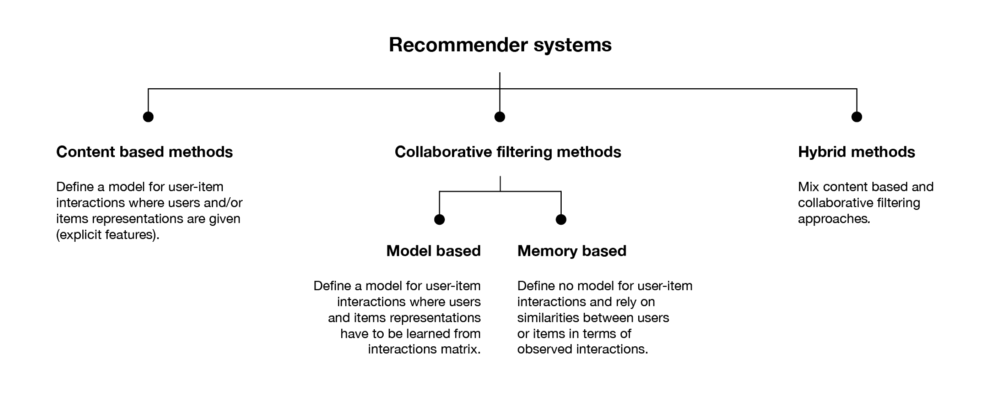



<div>
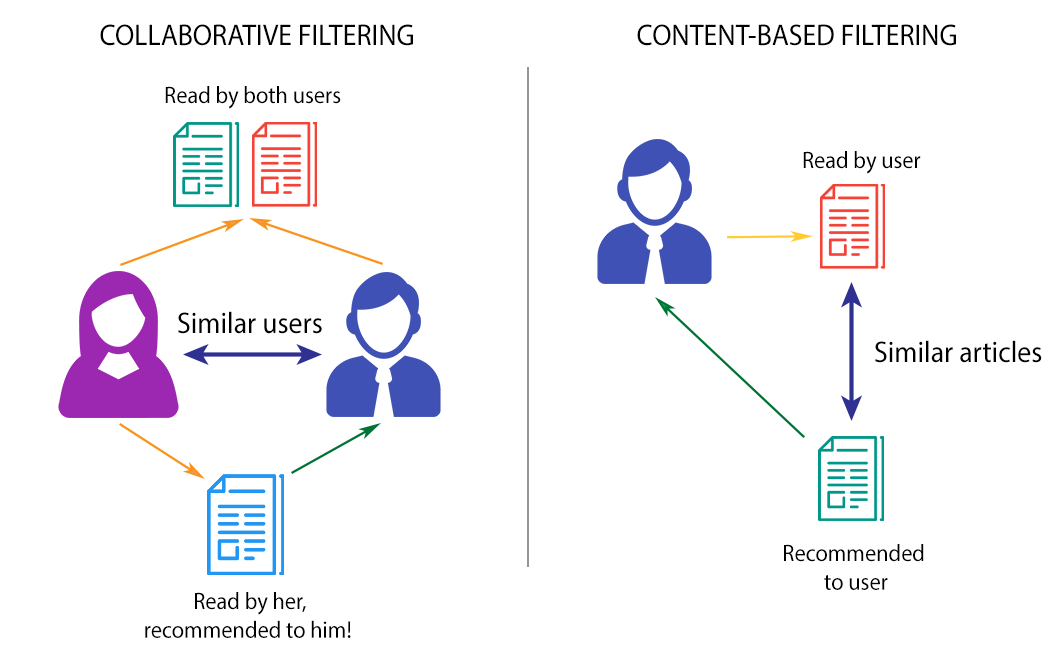
</div>

# Content-Based Filtering

* This type of filter does not involve other users if not ourselves. Based on what we like, the algorithm will simply pick items with similar content to recommend us.

* Cosine Similarity is one of the metric that we can use when calculating similarity, between users or contents.

* Content-based recommenders treat suggestions as a user-specific
category problem and learn a classifier for the customer's preferences depending on product traits. This approach is based on
information retrieval because content associated with the user’s preferences is treated as query to the system and unrated items
are scored with similar items

**The Content-based Filtering Approach**

Like the name suggests, the Content-based Filtering approach involves analyzing an item a user interacted with, and giving recommendations that are similar in content to that item. Content, in this case, refers to a set of attributes/features that describes your item. For a movie recommendation engine, a content-based approach would be to recommend movies that are of highest similarity based on its features, such as genres, actors, directors, year of production, etc. The assumption here is that users have preferences for a certain type of product, so we try to recommend a similar product to what the user has expressed liking for. Also, the goal here is to provide alternatives or substitutes to the item that was viewed.

In [23]:
movies <- read.csv("movies.csv",stringsAsFactors=FALSE)

In [24]:
str(movies)

'data.frame':	10329 obs. of  3 variables:
 $ movieId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ title  : chr  "Toy Story (1995)" "Jumanji (1995)" "Grumpier Old Men (1995)" "Waiting to Exhale (1995)" ...
 $ genres : chr  "Adventure|Animation|Children|Comedy|Fantasy" "Adventure|Children|Fantasy" "Comedy|Romance" "Comedy|Drama|Romance" ...


In [25]:
ratings <- read.csv("ratings.csv")

In [27]:
str(ratings)

'data.frame':	105339 obs. of  4 variables:
 $ userId   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ movieId  : int  16 24 32 47 50 110 150 161 165 204 ...
 $ rating   : num  4 1.5 4 4 4 4 3 4 3 0.5 ...
 $ timestamp: int  1217897793 1217895807 1217896246 1217896556 1217896523 1217896150 1217895940 1217897864 1217897135 1217895786 ...


**Data Preprocessing**

To obtain the movie features matrix, the pipe-separated genres available in the movies dataset had to be split. The data.table package has a tstrsplit() function that works well here to perform string splits.

In [28]:
genres <- as.data.frame(movies$genres, stringsAsFactors=FALSE)
library(data.table)
genres2 <- as.data.frame(tstrsplit(genres[,1], '[|]', type.convert=TRUE), stringsAsFactors=FALSE)
colnames(genres2) <- c(1:7)


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



This will give us a matrix that looks like this. This is basically movies$genres but each genre is separated into columns.

In [31]:
head(genres2)

1,2,3,4,5,6,7,NA,NA,NA
Adventure,Animation,Children,Comedy,Fantasy,NA,NA,NA,NA,NA
Adventure,Children,Fantasy,NA,NA,NA,NA,NA,NA,NA
Comedy,Romance,NA,NA,NA,NA,NA,NA,NA,NA
Comedy,Drama,Romance,NA,NA,NA,NA,NA,NA,NA
Comedy,NA,NA,NA,NA,NA,NA,NA,NA,NA
Action,Crime,Thriller,NA,NA,NA,NA,NA,NA,NA


Then you create a matrix with columns representing every unique genre, and indicate whether a genre was present or not in each movie.

In [35]:
genre_list <- c("Action", "Adventure", "Animation", "Children", "Comedy", "Crime","Documentary", "Drama", "Fantasy","Film-Noir", "Horror", "Musical", "Mystery","Romance","Sci-Fi", "Thriller", "War", "Western")
 
genre_matrix <- matrix(0,10330,18) #empty matrix
genre_matrix[1,] <- genre_list #set first row to genre list
colnames(genre_matrix) <- genre_list #set column names to genre list

In [36]:
#iterate through matrix
for (i in 1:nrow(genres2)) {
 for (c in 1:ncol(genres2)) {
 genmat_col = which(genre_matrix[1,] == genres2[i,c])
 genre_matrix[i+1,genmat_col] <- 1
 }
}

In [37]:
#convert into dataframe
genre_matrix2 <- as.data.frame(genre_matrix[-1,], stringsAsFactors=FALSE) #remove first row, which was the genre list
for (c in 1:ncol(genre_matrix2)) {
  genre_matrix2[,c] <- as.integer(genre_matrix2[,c])
} #convert from characters to integers

We have now obtained the movie genres matrix. Each column represents a unique movie genre, and each row is a unique movie. The table below just shows a preview of what the dataset looks like. We have 18 unique genres and 10330 unique movies.

In [39]:
head(genre_matrix2)

Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Now, what we need is a user profile matrix. This can be easily done with the dcast() function in the reshape2 package. I first convert the ratings into a binary format to keep things simple. ratings of 4 and 5 are mapped to 1, representing likes, and ratings of 3 and below are mapped to -1, representing dislikes.

In [40]:
binaryratings <- ratings
for (i in 1:nrow(binaryratings)){
 if (binaryratings[i,3] > 3){
   binaryratings[i,3] <- 1
 }
 else{
   binaryratings[i,3] <- -1
 }
}

In [41]:
head(binaryratings)

userId,movieId,rating,timestamp
1,16,1,1217897793
1,24,-1,1217895807
1,32,1,1217896246
1,47,1,1217896556
1,50,1,1217896523
1,110,1,1217896150


To obtain the binaryratings matrix in the correct format we need, I use the dcast() function in the reshape2 package. This basically transforms the data from a long format to a wide format. This also creates many NA values because not every user rated every movie. I substituted the NA values with 0.

In [42]:
binaryratings2 <- dcast(binaryratings, movieId~userId, value.var = "rating", na.rm=FALSE)
for (i in 1:ncol(binaryratings2)){
  binaryratings2[which(is.na(binaryratings2[,i]) == TRUE),i] <- 0
}
binaryratings2 = binaryratings2[,-1] #remove movieIds col. Rows are movieIds, cols are userIds

Now we have the binaryratings matrix in the right format. This matrix has 10325 rows, representing the movieIds, and 668 cols, representing the userIds. The matrix now looks something like this:

In [47]:
head(binaryratings2)

1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
0,1,0,0,1,0,0,1,0,0,...,0,0,1,1,-1,0,0,0,0,-1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,-1
0,-1,0,0,0,0,0,1,-1,0,...,0,0,-1,0,0,0,0,0,0,-1
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-1,-1,0,0,0,0,-1,0,0,...,0,0,-1,0,0,0,0,0,0,-1
0,0,0,0,0,0,0,0,1,0,...,-1,0,1,1,0,0,0,0,0,1


To create the simple user profile matrix, I calculated the dot product of the movie genre matrix and the binaryratings matrix. Before we proceed with the dot product, you might notice that the movies dataset has 10329 movies, but the ratings dataset only has 10325 movies. To deal with this, I removed the movies that have never been rated from the genres matrix.

In [51]:
#Remove rows that are not rated from movies dataset
movieIds <- length(unique(movies$movieId)) #10329
ratingmovieIds <- length(unique(ratings$movieId)) #10325
movies2 <- movies[-which((movieIds %in% ratingmovieIds) == FALSE),]
rownames(movies2) <- NULL
#Remove rows that are not rated from genre_matrix2
genre_matrix3 <- genre_matrix2[-which((movieIds %in% ratingmovieIds) == FALSE),]
rownames(genre_matrix3) <- NULL

Now we can calculate the dot product of the genre matrix and the ratings matrix and obtain the user profiles.



In [1]:
(warn=-1)
#Calculate dot product for User Profiles
result = matrix(0,18,668)
for (c in 1:ncol(binaryratings2)){
  for (i in 1:ncol(genre_matrix3)){
    result[i,c] <- sum((genre_matrix3[,i]) * (binaryratings2[,c]))
  }
}
 
#Convert to Binary scale
for (i in 1:nrow(result)){
  if (result[i] < 0){
    result[i] <- 0
  }
  else {
    result[i] <- 1
  }
}

In [68]:
result2 <- result[1,] #First user's profile
sim_mat <- rbind.data.frame(result2, genre_matrix3)
sim_mat <- data.frame(lapply(sim_mat,function(x){as.integer(x)})) #convert data to type integer
 
#Calculate Jaccard distance between user profile and all movies
library(proxy)
sim_results <- dist(sim_mat, method = "Jaccard")
sim_results <- as.data.frame(as.matrix(sim_results[1:8552]))
rows <- which(sim_results == min(sim_results))
#Recommended movies
movies[rows,]

,movieId,title,genres
2388,2986,RoboCop 2 (1990),Action|Crime|Sci-Fi|Thriller
7348,52460,Pathfinder (2007),Action|Adventure|Drama|Thriller|War
7558,56145,"Mist, The (2007)",Horror|Sci-Fi


In [65]:
dim(sim_results)

[1] 8552    1

# Recommender System Using Collaborative Filtering

## 1. Introduction

Collaborative filtering is a technique used by recommender systems for predicting the interests of one user based on the preference information of other users. This project is an implementation of a Movie Recommender System that uses the following techniques:

    * Item-Item Collaborative Filtering
    * User-User Collaborative Filtering


* Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.
* It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

This implementation uses the recommenderlab package in R. The MovieLense dataset is included with this package and is used here to train, predict and evaluate the models.

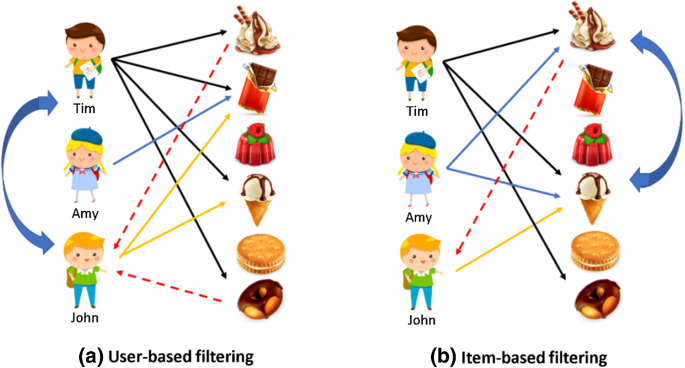

The following R libraries are used in this project.

In [77]:
(warn=-1)
library(dplyr)
library(ggplot2)
library(knitr)
library(recommenderlab)

[1] -1

## 2 Data Exploration
The starting point in collaborative filtering is a rating matrix in which rows correspond to users and columns correspond to items. This matrix is implemented in the MovieLense data object.

We now load and inspect the MovieLense data object.

In [78]:
data(MovieLense)
MovieLense

943 x 1664 rating matrix of class 'realRatingMatrix' with 99392 ratings.

In [79]:
class(MovieLense)

[1] "realRatingMatrix"
attr(,"package")
[1] "recommenderlab"

In [80]:
slotNames(MovieLense)

[1] "data"      "normalize"

In [81]:
class(MovieLense@data)

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

We now show names of some of the movies present in the data set.

In [82]:
head(names(colCounts(MovieLense)))

[1] "Toy Story (1995)"                                    
[2] "GoldenEye (1995)"                                    
[3] "Four Rooms (1995)"                                   
[4] "Get Shorty (1995)"                                   
[5] "Copycat (1995)"                                      
[6] "Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)"

The number of ratings corresponding to each rating value is shown in a table below.

In [83]:
vector_ratings <- as.vector(MovieLense@data)
kable(table(vector_ratings), caption="Rating frequency")



|vector_ratings |    Freq|
|:--------------|-------:|
|0              | 1469760|
|1              |    6059|
|2              |   11307|
|3              |   27002|
|4              |   33947|
|5              |   21077|

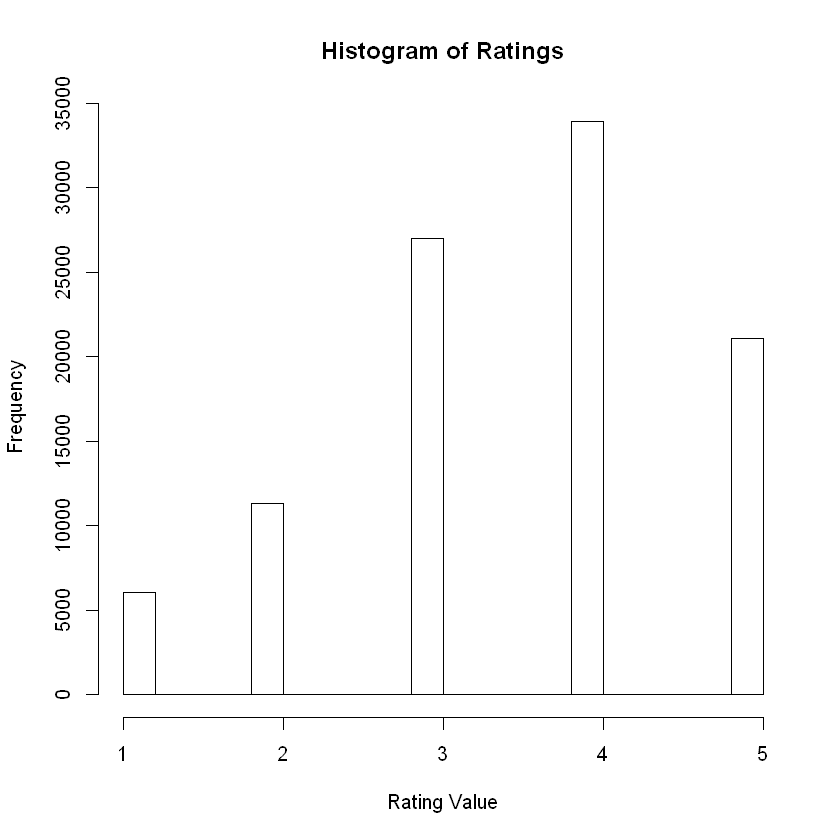

In [84]:
# Since a rating of 0 represents absence of a rating in this data set, we can remove such
# ratings from the ratings vector.

vector_ratings = vector_ratings[vector_ratings != 0]
hist(vector_ratings, main="Histogram of Ratings", xlab="Rating Value")

We see above that the rating of 4 (indicating high preference) is the most common rating, and that rating values are skewed to the left.

## 3 Data Preparation
### 3.1 Minimum Thresholds
For building a collaborative filtering model we can limit the input data based on minimum thresholds: for example, we may ignore users that have provided too few ratings, and also ignore those movies that have received too few ratings from users.

Here we restrict the model training to those users who have rated at least 50 movies, and those movies that have been rated by at least 100 users.

In [85]:
ratings = MovieLense[rowCounts(MovieLense) > 50, colCounts(MovieLense) > 100]
dim(ratings)

[1] 560 332

### NOTE

_We can also normalize the data so that the average rating given by each user is 0. This handles cases where a user consistently assigns higher or lower ratings to all movies compared to the average for all users. In other words, normalizing of data is done to remove the bias in each user’s ratings._

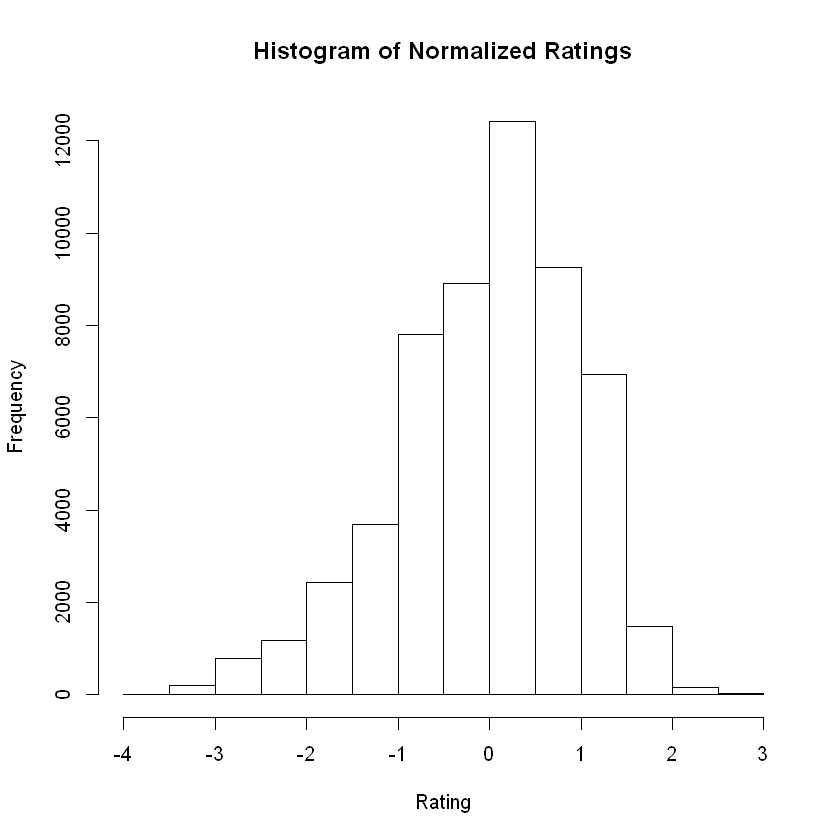

In [86]:
#Example
ratings.n = normalize(ratings)
ratings.n.vec = as.vector(ratings.n@data)
ratings.n.vec = ratings.n.vec[ratings.n.vec != 0]
hist(ratings.n.vec, main="Histogram of Normalized Ratings", xlab="Rating")

### 3.2 Splitting data for test and train
For splitting data into test and train sets, we can use the evaluationScheme() function in recommenderlab. It extends the usage of generic methods of splitting the data, by allowing several parameters that are specific to recommender systems. As shown in the code section below, there is a parameter specifying how many items to use for each user, and another parameter specifying the minimum value that indicates a good rating.

In [87]:
percent_train = 0.8
#min(rowCounts(ratings.n))
items_to_keep = 15        # items to use for each user
rating_threshold = 3      # good rating implies >=3
n_eval = 1                # number of times to run eval

eval_sets = evaluationScheme(data = ratings, method = "split",
                             train = percent_train, given = items_to_keep,
                             goodRating = rating_threshold, k = n_eval)
eval_sets

Evaluation scheme with 15 items given
Method: 'split' with 1 run(s).
Training set proportion: 0.800
Good ratings: >=3.000000
Data set: 560 x 332 rating matrix of class 'realRatingMatrix' with 55298 ratings.

## 4 User-User Collaborative Filtering
In user-based collaborative filtering (UBCF) the procedure is to first find other users that are similar to a given user, then find the top-rated items purchased by those users. Those items are then recommended for the given user [3].

We now build a UBCF model using the default parameters of the Recommender() function, and use it to predict using the test portion of the data set. We use library functions to evaluate accuracy of the prediction by comparing against values in the data set. Performance metrics for the UBCF model are displayed.

In [114]:
eval_recommender = Recommender(data = getData(eval_sets, "train"),
                               method = "UBCF", parameter = NULL)
items_to_recommend = 10
eval_prediction = predict(object = eval_recommender,
                          newdata = getData(eval_sets, "known"),
                          n = items_to_recommend,
                          type = "ratings")
eval_accuracy = calcPredictionAccuracy(x = eval_prediction,
                                       data = getData(eval_sets, "unknown"),
                                       byUser = TRUE)
head(eval_accuracy)

,RMSE,MSE,MAE
6,1.1403192,1.3003280,0.9142936
7,1.1292976,1.2753130,0.8212592
10,0.8155843,0.6651777,0.6447330
23,1.1352064,1.2886936,0.9571869
38,1.8652956,3.4793276,1.5350564
41,0.9466160,0.8960818,0.6980753


In [115]:
# Convert all your recommendations to list structure
rec_list <- as(eval_prediction, "list")

In [116]:
# Access this list. User 1, item at index 1
rec_list[[1]][1]

GoldenEye (1995) 
        3.329167

In [117]:
# Convert to data frame all recommendations for user 1
u1<-as.data.frame(rec_list[[1]])
#attributes(u1)
class(u1)

[1] "data.frame"

In [118]:
# Create a column by name of id in data frame u1 and populate it with row names
u1$id<-row.names(u1)
# Now access top 6 movie predictions in for u1$id = 3952
head(u1[u1$id==3952])

GoldenEye (1995)
Get Shorty (1995)
Twelve Monkeys (1995)
Babe (1995)
Dead Man Walking (1995)
Seven (Se7en) (1995)


## 5 Item-Item Collaborative Filtering
Item-based collaborative filtering (IBCF) attempts to find, for a given user, items that are similar to items purchased by the user.

The core algorithm is based on these steps:

For each two items, measure how similar they are in terms of having received similar ratings by similar users.
For each item, identify the k-most similar items.
For each user, identify the items that are most similar to the user’s purchases.
We now build an IBCF model using the default parameters of the Recommender() function.

In [119]:
eval_recommender = Recommender(data = getData(eval_sets, "train"),
                               method = "IBCF", parameter = NULL)
items_to_recommend = 10
eval_prediction = predict(object = eval_recommender,
                          newdata = getData(eval_sets, "known"),
                          n = items_to_recommend,
                          type = "ratings")
eval_accuracy = calcPredictionAccuracy(x = eval_prediction,
                                       data = getData(eval_sets, "unknown"),
                                       byUser = TRUE)
head(eval_accuracy)

,RMSE,MSE,MAE
6,1.2477943,1.5569907,0.9478161
7,1.3069337,1.7080757,0.9487744
10,0.7204067,0.5189859,0.5241383
23,1.4203915,2.0175121,1.1158685
38,2.0429693,4.1737235,1.3920296
41,1.1428626,1.3061350,0.8148277


We find from the above accuracy tables that RMSE values are significantly lower for the UBCF model.

In [120]:
# Convert all your recommendations to list structure
rec_list <- as(eval_prediction, "list")

In [121]:
# Access this list. User 1, item at index 1
rec_list[[1]][1]

Get Shorty (1995) 
         3.726827

In [122]:
# Convert to data frame all recommendations for user 1
u1<-as.data.frame(rec_list[[1]])
#attributes(u1)
class(u1)

[1] "data.frame"

In [123]:
# Create a column by name of id in data frame u1 and populate it with row names
u1$id<-row.names(u1)
# Now access top 6 movie predictions in for u1$id = 3952
head(u1[u1$id==3952])

Get Shorty (1995)
Twelve Monkeys (1995)
Babe (1995)
Seven (Se7en) (1995)
"Usual Suspects, The (1995)"
Mighty Aphrodite (1995)




## 6 Evaluating Models using different Similarity Parameters
We now build models using different similarity parameters for computing similarity between users and items. The cosine similarity and the Pearson correlation are commonly used similarity measures and are used here.

In [18]:
models_to_evaluate = list(IBCF_cos = list(name = "IBCF", param = list(method = "cosine")),
                          IBCF_cor = list(name = "IBCF", param = list(method = "pearson")),
                          UBCF_cos = list(name = "UBCF", param = list(method = "cosine")),
                          UBCF_cor = list(name = "UBCF", param = list(method = "pearson")),
                          random = list(name = "RANDOM", param=NULL))

n_recommendations = c(1, 3, 5, 10, 15, 20)
results = evaluate(x = eval_sets, method = models_to_evaluate, n = n_recommendations)

IBCF run fold/sample [model time/prediction time]
	 1  [0.26sec/0.03sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.32sec/0.04sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.17sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.19sec] 
RANDOM run fold/sample [model time/prediction time]
	 1  [0sec/0.01sec] 


## 7 Comparing the Collaborative Filtering Models

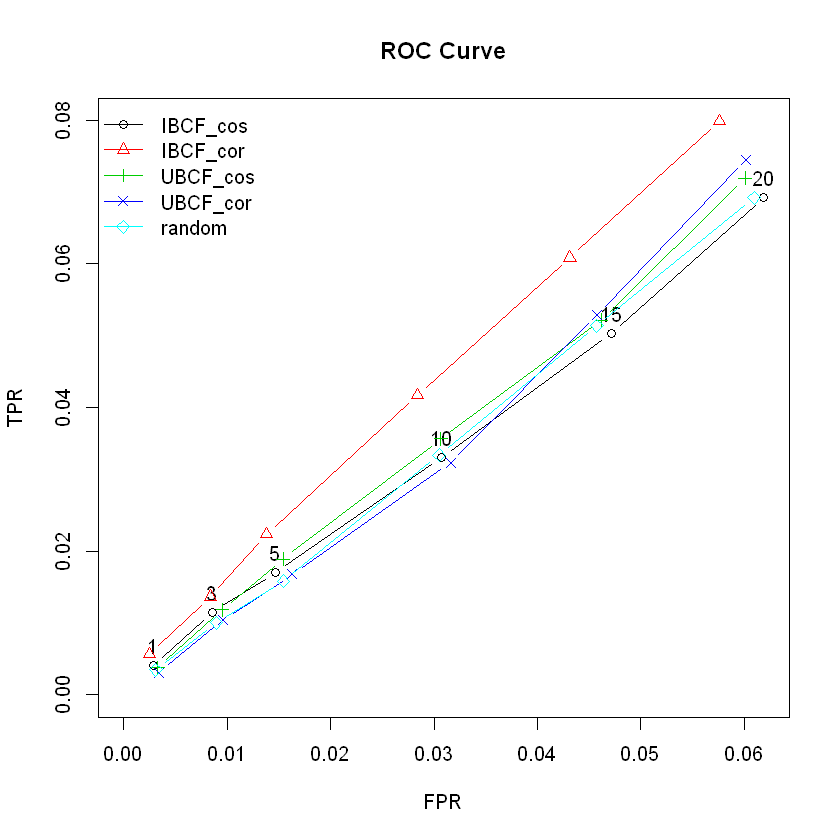

In [19]:
# Draw ROC curve
plot(results, y = "ROC", annotate = 1, legend="topleft")
title("ROC Curve")

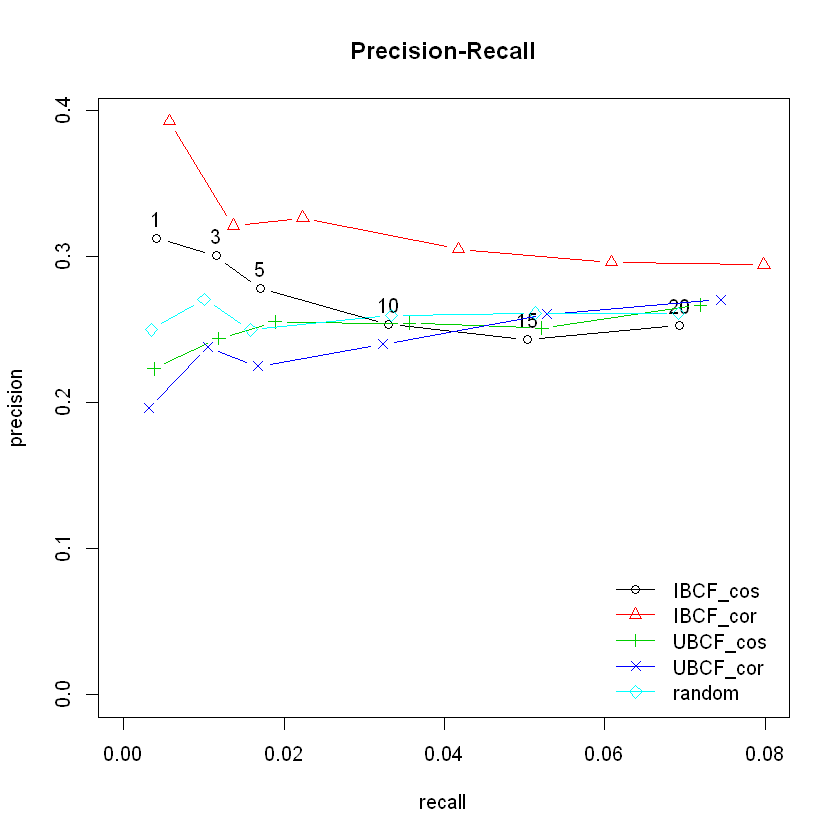

In [20]:
# Draw precision / recall curve
plot(results, y = "prec/rec", annotate=1)
title("Precision-Recall")

## Conclusions
We see that UBCF’s accuracy is higher than that of IBCF. UBCF using Pearson Correlation outperforms all other models. On the other hand, UBCF has greater computational cost and requires more resources. There also exist hybrid systems that integrate both UBCF and IBCF approaches. It is also worth noting that both UBCF and IBCF have limitations – for example when handling users who have made no purchases or items without a single purchase (the cold-start problem).

https://medium.com/@wwwbbb8510/comparison-of-user-based-and-item-based-collaborative-filtering-f58a1c8a3f1d

https://www.r-bloggers.com/2012/06/testing-recommender-systems-in-r/

https://cran.r-project.org/web/packages/recommenderlab/vignettes/recommenderlab.pdf